In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Experimental data

Data shapes
Sqh:  (50, 2, 2, 236, 200)
Cad:  (50, 236, 200)
Vel:  (50, 2, 236, 200)


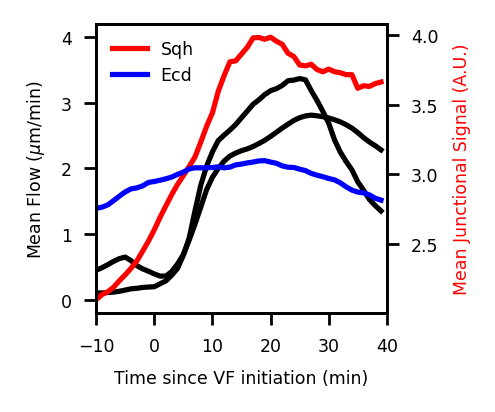

In [2]:
plt.rcParams['font.size'] = 5

loaddir = 'Public/WT/ECad-GFP/ensemble/'
cad = np.load(os.path.join(loaddir, 'cyt2D.npy'), mmap_mode='r')
cad_vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')

loaddir = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')
vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')
t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
DV = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
AP = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')

dv = DV[:, 0]
ap = AP[0, :]

nDV = dv.shape[0]
nAP = ap.shape[0]
nTP = t.shape[0]
    
sqh = sqh * 3e1
cad = cad * 1.5e0
    
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax.plot(t, np.linalg.norm(cad_vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)), 
         color='red', label='Sqh')
ax2.plot(t, cad.mean(axis=(1, 2)), 
         color='blue', label='Ecd')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 40])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal (A.U.)', color='red')
ax.set_xlabel('Time since VF initiation (min)')

from scipy.ndimage import gaussian_filter
cad = np.stack([
    gaussian_filter(cad[i], sigma=4) for i in range(cad.shape[0])])
print('Data shapes')
print('Sqh: ', sqh.shape)
print('Cad: ', cad.shape)
print('Vel: ', vel.shape)

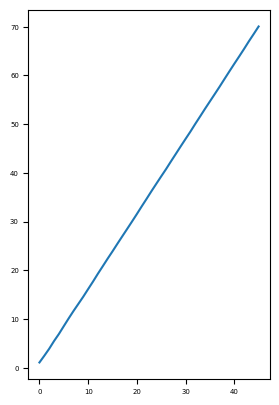

In [12]:
def radial_average(arr, num_bins=100):
    arr = arr.reshape([nDV, nAP])
    center = (nDV // 2, nAP // 2)

    x, y = np.meshgrid(np.arange(nAP), np.arange(nDV), indexing='xy')
    distances = np.hypot(x - center[1], y - center[0])

    sorted_distances = np.sort(distances.ravel())
    sorted_values = arr.ravel()[np.argsort(distances.ravel())]

    bins = np.linspace(0, (nAP/(2 * np.sqrt(2))), num_bins + 1)
    bins = np.linspace(0, sorted_distances.max(), num_bins+1)
    bin_indices = np.digitize(sorted_distances, bins)

    radial_avg = np.bincount(bin_indices, weights=sorted_values) / np.bincount(bin_indices)
    
    trunc = bins < nAP / (2 * 1.414)
    return radial_avg[1:][trunc]

qAP = np.fft.fftshift(np.fft.fftfreq(nAP, d=ap[1]-ap[0])) * np.ptp(AP)
qDV = np.fft.fftshift(np.fft.fftfreq(nDV, d=dv[1]-dv[0])) * np.ptp(DV)
q = np.linalg.norm(np.meshgrid(qAP, qDV, indexing='xy'), axis=0)
q = radial_average(q)
ax = plt.figure().gca()
ax.plot(np.arange(len(q)), q)
ax.set_aspect('equal')

Text(0, 0.5, '$|m(\\mathbf{q})|$')

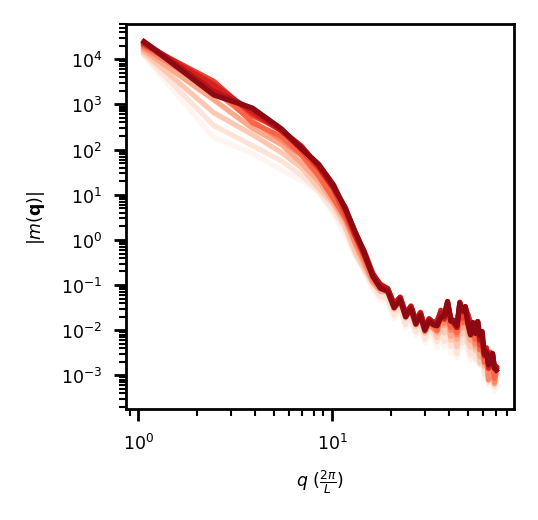

In [13]:
from scipy.signal import blackman, hann

window_AP = hann(nAP)
window_DV = hann(nDV)
window = window_AP[None, :] * window_DV[:, None]

sqh_q = np.sqrt(np.abs(np.fft.fft2(sqh * window))**2)
#sqh_q = np.sqrt(np.abs(np.fft.fft2(sqh))**2)

trm_q = np.einsum('tjjyx->tyx', sqh_q)
sqh_q = np.fft.ifftshift(sqh_q, axes=(-2, -1))
trm_q = np.fft.ifftshift(trm_q, axes=(-2, -1))
sqh_qt = np.apply_along_axis(radial_average, 1, trm_q.reshape([nTP, -1]))
cmap = plt.cm.Reds
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, sqh_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$q\ (\frac{2\pi}{L})$')
ax.set_ylabel(r'$|m(\mathbf{q})|$')

Text(0, 0.5, '$|c(\\mathbf{q})|$')

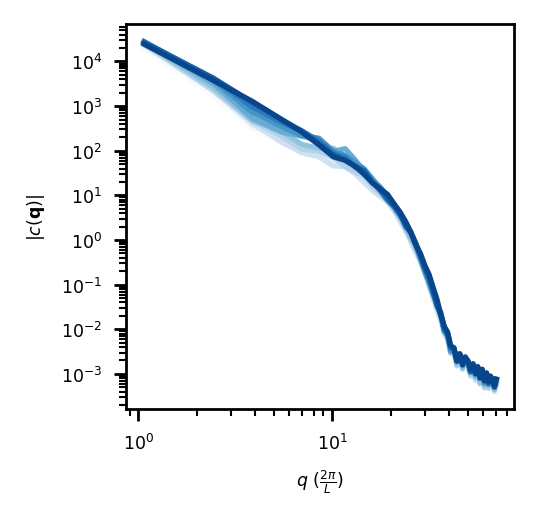

In [14]:
cad_q = np.sqrt(np.abs(np.fft.fft2(cad * window))**2)
#cad_q = np.sqrt(np.abs(np.fft.fft2(cad))**2)
cad_q = np.fft.ifftshift(cad_q, axes=(-2, -1))
cad_qt = np.apply_along_axis(radial_average, 1, cad_q.reshape([nTP, -1]))

cmap = plt.cm.Blues
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, cad_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$q\ (\frac{2\pi}{L})$')
ax.set_ylabel(r'$|c(\mathbf{q})|$')

Text(0, 0.5, '$|v(\\mathbf{q})|^2$')

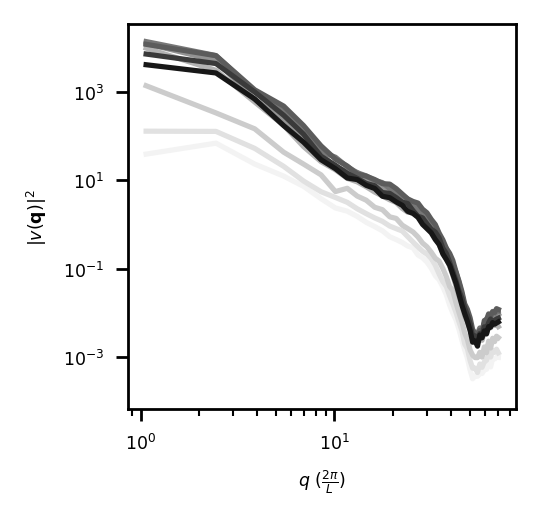

In [15]:
vel_q = np.sqrt(np.abs(np.fft.fft2(vel * window))**2)
#vel_q = np.sqrt(np.abs(np.fft.fft2(vel))**2)

vel_q = np.fft.ifftshift(vel_q, axes=(-2, -1))
vel_qt = np.apply_along_axis(radial_average, 1, vel_q[:, 0].reshape([nTP, -1]))

cmap = plt.cm.Greys
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, vel_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$q\ (\frac{2\pi}{L})$')
ax.set_ylabel(r'$|v(\mathbf{q})|^2$')

From the Stokes equation, we have
\begin{equation}
    v_i (\mathbf{q}) = -\frac{i \alpha}{\eta q^2} \left[\delta_{ij} - \frac{q_i q_j}{q^2} \right] q_k m_{jk} (\mathbf{q})
\end{equation}

Then if $m_{ij} (\mathbf{q}) \sim q^{-t}$, then $v_i(\mathbf{q}) \sim q^{-t-1}$

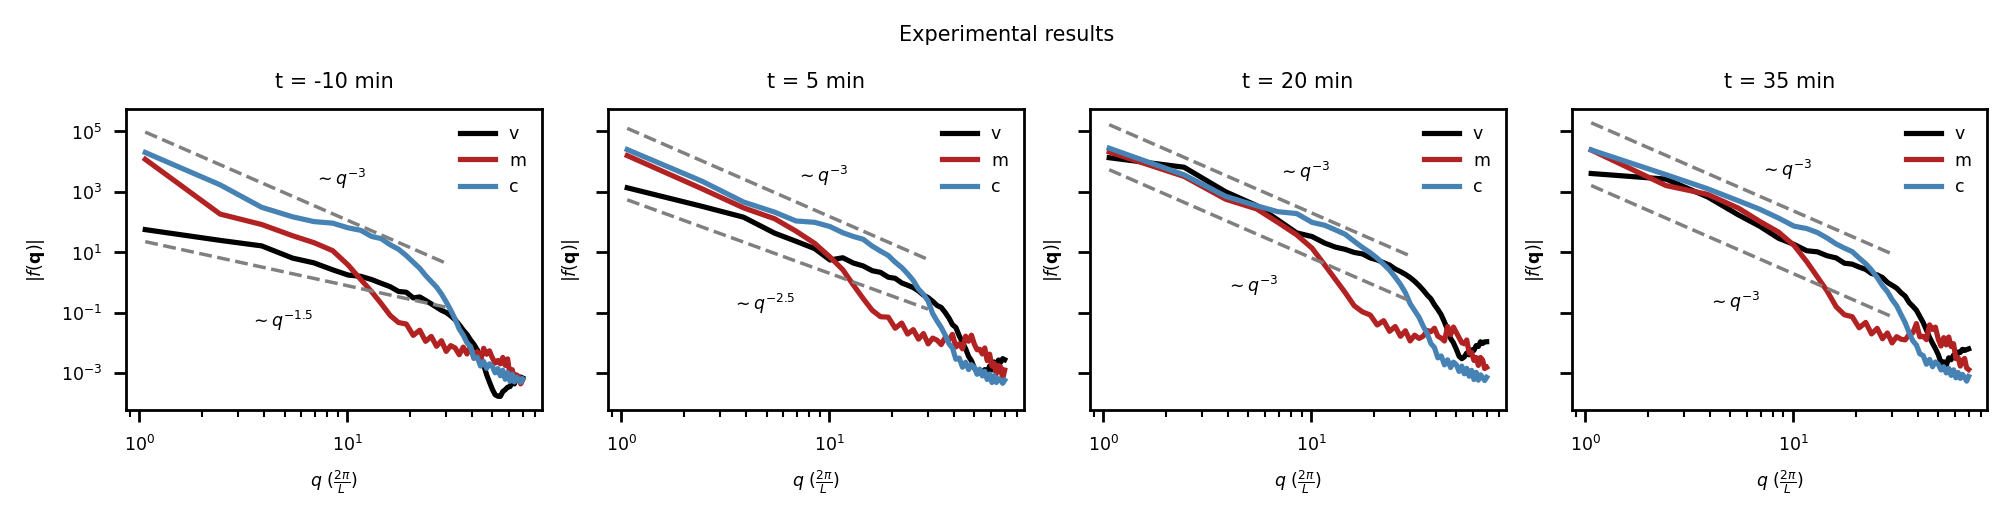

In [16]:
tt = [0, 15, 30, 45]
exps = -3
fig, ax = plt.subplots(1, len(tt), dpi=250, figsize=(2*len(tt), 2), sharex=True, sharey=True)
for i in range(len(tt)):
    ax[i].plot(q, vel_qt[tt[i]], color='black', label='v')
    ax[i].plot(q, sqh_qt[tt[i]], color='firebrick', label='m')
    ax[i].plot(q, cad_qt[tt[i]], color='steelblue', label='c')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'$q\ (\frac{2\pi}{L})$')
    ax[i].set_ylabel(r'$|f(\mathbf{q})|$')
    ax[i].legend(framealpha=0)
    ax[i].set_title(f't = {t[tt[i]]} min')
    
    exp = exps
    if t[tt[i]] < 0:
        exp2 = exp + 1.5
    elif t[tt[i]] < 10:
        exp2 = exp + 0.5
    else:
        exp2 = exp

    qs = q[:20]
    qe1 = np.power(qs, exp)
    
    qe2 = np.power(qs, exp2)

    qe1 = 8e0  * sqh_qt[tt[i], 0] * (qe1 / qe1[0])
    qe2 = 4e-1 * vel_qt[tt[i], 0] * (qe2 / qe2[0])
    ax[i].plot(qs, qe1, color='grey', linestyle='--', linewidth=1)
    ax[i].plot(qs, qe2, color='grey', linestyle='--', linewidth=1)
    ax[i].text(qs[4], qe1[4] * 3e0, r'$\sim q^{%g}$' % (exp),
                   va='bottom', ha='left')
    ax[i].text(qs[4], qe2[4] * 1e-1, r'$\sim q^{%g}$' % (exp2),
                   va='top', ha='right')    

fig.suptitle('Experimental results')

plt.tight_layout()

# Toy model

[[-1.  0. -1.]
 [ 0.  4.  0.]
 [-1.  0. -1.]]
[[[-0.-97.5j  0. +0.j  -0.-97.5j]
  [ 0. +0.j   0. +0.j   0. +0.j ]
  [ 0.-32.5j  0. +0.j   0.-32.5j]]

 [[-0.-32.5j  0. +0.j   0.+32.5j]
  [ 0. +0.j   0. +0.j   0. +0.j ]
  [-0.-32.5j  0. +0.j   0.+32.5j]]]


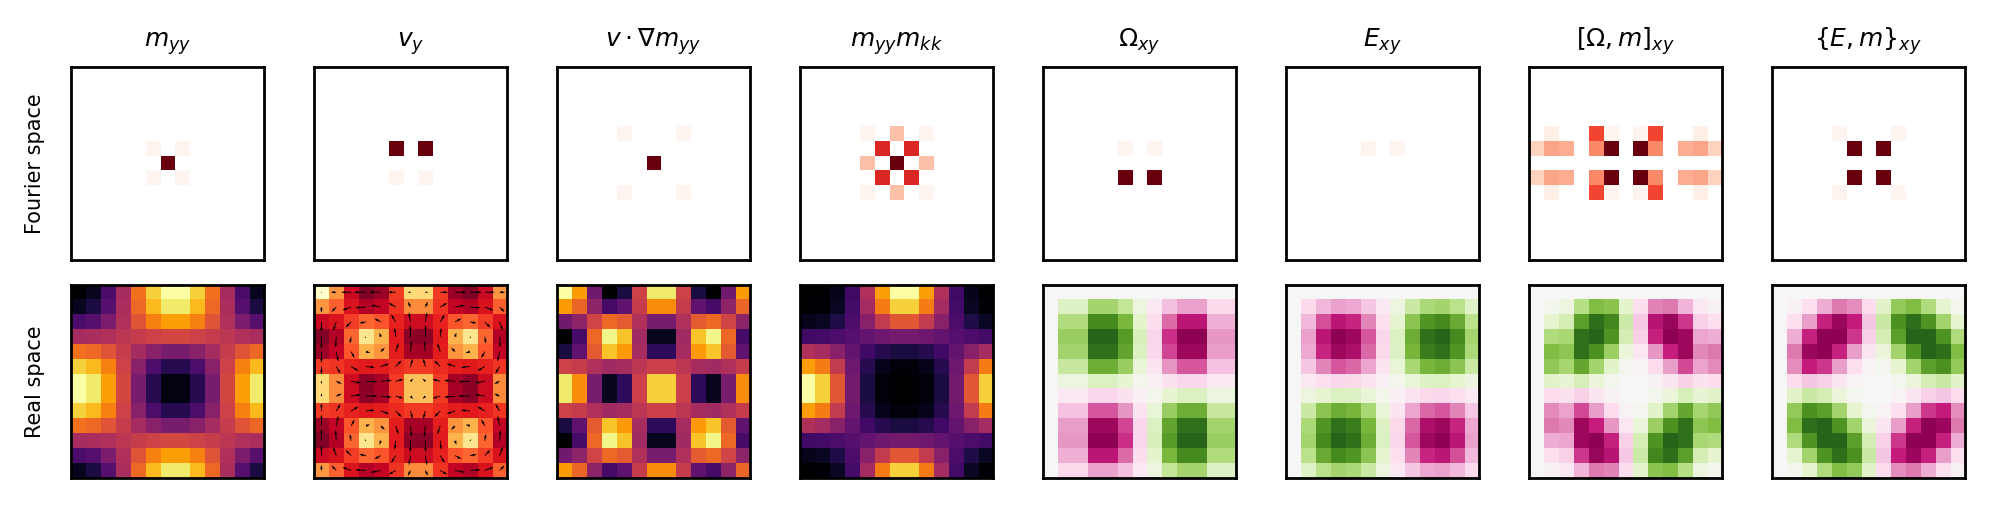

In [2]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['font.size'] = 6

def unshift(f):
    x = np.abs(f)**2
    x /= np.max(x)
    x[x < 1e-3] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[np.isnan(x)] = -1e8
    return x


N = 13
qx = np.fft.fftfreq(N, 10)
qy = np.fft.fftfreq(N, 10)
qi = np.stack(np.meshgrid(qx, qy, indexing='ij'))
q = np.linalg.norm(qi, axis=0)

eps = 1e-8
#Define myosin tensor
mq = np.zeros([2, 2, N, N])
mq[0, 0, 1, 1] = -1
mq[0, 0, 1, -1] = -1
mq[0, 0, -1, 1] = -1
mq[0, 0, -1, -1] = -1
mq[0, 0, 0, 0] = 4
#mq[0, 0, N//2, N//2+1] = .0
mq[np.abs(mq) < eps] = 0
mij = np.fft.ifft2(mq).real

vq = -1j * qi * q[0]**2 / q**4 * mq[0, 0]
vq[0] += 1j * q[0] / q**2 * mq[0, 0]
vq[:, 0, 0] = 0
print(np.fft.fftshift(mq, axes=(-2, -1))[0, 0, 5:8, 5:8])
print(np.fft.fftshift(vq, axes=(-2, -1))[:, 5:8, 5:8])
vi = np.fft.ifft2(vq).real

grad_mq = 1.0j * qi[:, None, None] * mq[None]
grad_mij = np.fft.ifft2(grad_mq).real
vgrad_mij = np.einsum('kyx,kijyx->ijyx', vi, grad_mij)
vgradmq = np.fft.fft2(vgrad_mij)

m2 = np.einsum('kkyx,ijyx->ijyx', mij, mij)
m2q = np.fft.fft2(m2)

wq = -1j * (qi[1] * vq[0] - qi[0] * vq[1])
wq[np.abs(mq[0, 0]) < eps] = 0
Oxy = np.fft.ifft2(wq).real

eq = -1j * np.einsum('iyx,jyx->ijyx', qi, vq) * 1e5
eq = eq + np.einsum('ijyx->jiyx', eq)
eq[:, :, np.abs(mq[0, 0]) < eps] = 0
Eij = np.fft.ifft2(eq).real

eps_ij = np.array([[0, -1], [1, 0]])
Om = Oxy * (np.einsum('ik,kjyx->ijyx', eps_ij, mij) + np.einsum('ikyx,kj->ijyx', mij, eps_ij))
Omq = np.fft.fft2(Om)

Em = np.einsum('ikyx,kjyx->ijyx', Eij, mij) + np.einsum('ikyx,kjyx->ijyx', mij, Eij)
Emq = np.fft.fft2(Em)

fig, ax = plt.subplots(2, 8, dpi=250, figsize=(8, 2))

kwargs = dict(cmap='Reds', extent=[qx.min(), qx.max(), qy.min(), qy.max()], interpolation='None')
ax[0, 0].imshow(unshift(mq[0, 0]), **kwargs)
ax[1, 0].imshow(mij[0, 0], cmap='inferno')
ax[0, 0].set_title(r'$m_{yy}$')

ax[0, 1].imshow(unshift(vq[0]), **kwargs)
ax[1, 1].quiver(vi[1], vi[0])
ax[1, 1].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 1].set_title(r'$v_y$')

ax[0, 2].imshow(unshift(vgradmq[0, 0]), **kwargs)
ax[1, 2].imshow(vgrad_mij[0, 0], cmap='inferno')
ax[0, 2].set_title(r'$v \cdot \nabla m_{yy}$')

ax[0, 3].imshow(unshift(m2q[0, 0]), **kwargs)
ax[1, 3].imshow(m2[0, 0], cmap='inferno')
ax[0, 3].set_title(r'$m_{yy} m_{kk}$')

ax[0, 4].imshow(unshift(wq), **kwargs)
ax[1, 4].imshow(Oxy, cmap='PiYG')
ax[0, 4].set_title('$\Omega_{xy}$')

ax[0, 5].imshow(unshift(eq[1, 0]), **kwargs)
ax[1, 5].imshow(Eij[1, 0] * 1e10, cmap='PiYG')
ax[0, 5].set_title('$E_{xy}$')

ax[0, 6].imshow(unshift(Omq[1, 0]), **kwargs)
ax[1, 6].imshow(Om[1, 0] * 1e10, cmap='PiYG')
ax[0, 6].set_title(r'$[\Omega, m]_{xy}$')

ax[0, 7].imshow(unshift(Emq[1, 0]), **kwargs)
ax[1, 7].imshow(Em[1, 0] * 1e10, cmap='PiYG')
ax[0, 7].set_title(r'$\{E, m\}_{xy}$')

for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

If we want a stable myosin intensity pattern, we can consider that component of the myosin dynamics equation $\dot{\mathbf{m}} + \mathbf{v} \cdot \nabla m = A (1 - \kappa \, c) \mathbf{m} + B \mathbf{m} \text{Tr}(\mathbf{m}) $. Taking $\dot{m} \rightarrow 0$ and a Fourier transform, we obtain
\begin{equation}
\sum_{q,k} \left[ i \mathbf{q} \cdot \mathbf{v}_{\mathbf{q}} m_{\mathbf{k}} - A (\delta_{qk} - \kappa c_{\mathbf{q}}) m_{\mathbf{k}} - B m_{\mathbf{q}} m_{\mathbf{k}}\right] e^{i (q + k) x} = 0
\end{equation}

Thus, to make a given myosin/flow pattern a fixed point, we simply require that, for all $\mathbf{q}$
\begin{equation}
    c_{\mathbf{q}} = \frac{\left[ m_{\mathbf{q}} - \frac{1}{A} \left( i \mathbf{q} \cdot \mathbf{v}_{\mathbf{q}} - B m_{\mathbf{q}} \right) \sum_k m_{\mathbf{k}} e^{i k x} \right]}{\kappa \sum_k m_{\mathbf{k}} e^{i k x} }
\end{equation}

\begin{equation}
    c_{\mathbf{q}} = - \frac{1}{A\kappa} \left( i \mathbf{q} \cdot \mathbf{v}_{\mathbf{q}} - B m_{\mathbf{q}} \right) + \frac{m_{\mathbf{q}}}{\kappa \sum_k m_{\mathbf{k}} e^{i k x} }
\end{equation}

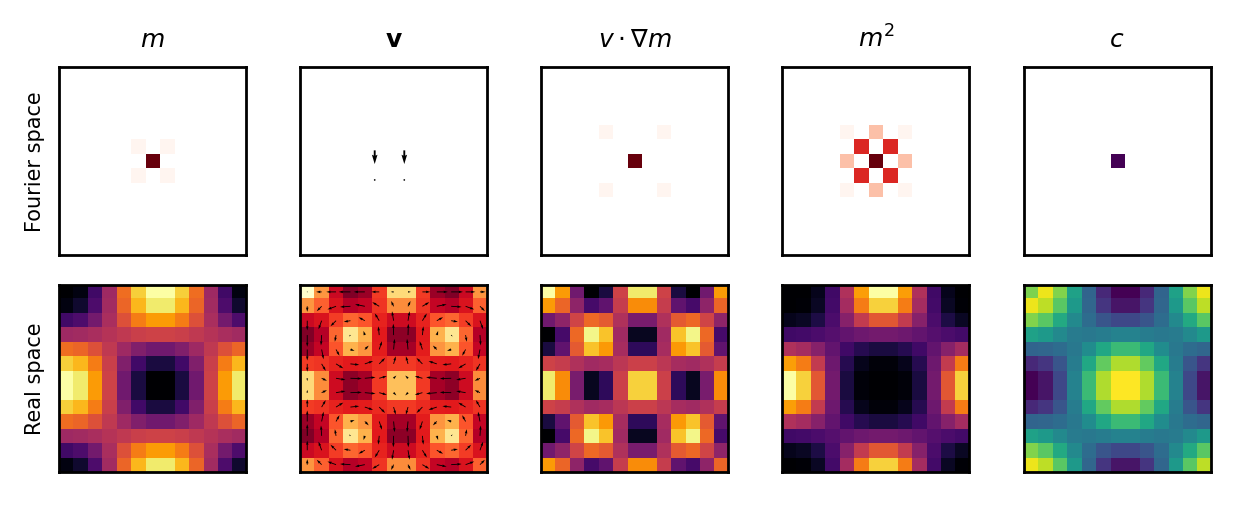

In [52]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['font.size'] = 6


def unshift(f):
    x = np.abs(f)**2
    x /= np.max(x)
    x[x < 1e-3] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[np.isnan(x)] = -1e8
    return x

#Define myosin tensor
mq = np.zeros([N, N])
mq[1, 1] = -1
mq[1, -1] = -1
mq[-1, 1] = -1
mq[-1, -1] = -1
mq[0, 0] = 4
mq[np.abs(mq) < eps] = 0
m = np.fft.ifft2(mq).real
m[m == 0] = np.min(m[m != 0])

vq = -1j * qi * q[0]**2 / q**4 * mq
vq[0] += 1j * q[0] / q**2 * mq
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real

grad_mq = 1.0j * qi * mq[None]
grad_m = np.fft.ifft2(grad_mq).real
vgrad_m = np.einsum('kyx,kyx->yx', vi, grad_m)
vgradmq = np.fft.fft2(vgrad_m)

m2q = np.fft.fft2(m*m)

A, B, k = 1, -1, 0.6
c = (A * m + B * m**2 - vgrad_m) / (k * m)
#c[m == 0] = 0
cq= np.fft.fft2(c)

fig, ax = plt.subplots(2, 5, dpi=250, figsize=(5, 2))

kwargs = dict(cmap='Reds', extent=[qx.min(), qx.max(), qy.min(), qy.max()], interpolation='None')
ax[0, 0].imshow(unshift(mq), **kwargs)
ax[1, 0].imshow(m, cmap='inferno')
ax[0, 0].set_title(r'$m$')

ax[0, 1].imshow(unshift(vq[0]), **kwargs)
ax[0, 1].quiver(unshift(vq[1]), unshift(vq[0]), scale=3e1, width=0.01)
ax[1, 1].quiver(vi[1], vi[0])
ax[1, 1].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
ax[0, 1].set_title(r'$\mathbf{v}$')

ax[0, 2].imshow(unshift(vgradmq), **kwargs)
ax[1, 2].imshow(vgrad_m, cmap='inferno')
ax[0, 2].set_title(r'$v \cdot \nabla m$')

ax[0, 3].imshow(unshift(m2q), **kwargs)
ax[1, 3].imshow(m*m, cmap='inferno')
ax[0, 3].set_title(r'$m^2$')

ax[0, 4].imshow(unshift(cq))
ax[1, 4].imshow(c, cmap='viridis')
ax[0, 4].set_title(r'$c$')

for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()

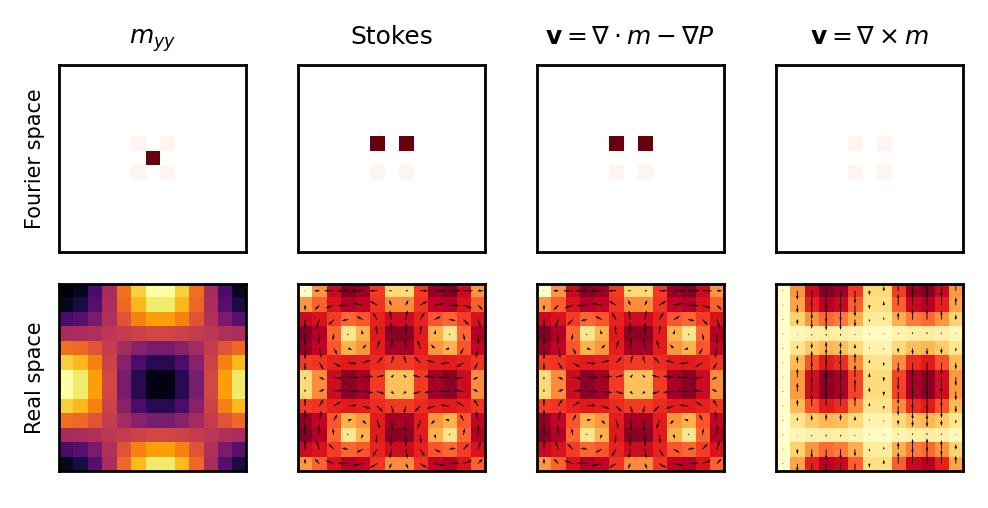

In [3]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['font.size'] = 6

def unshift(f):
    x = np.abs(f)**2
    x /= np.max(x)
    x[x < 1e-3] = 0
    x = np.fft.fftshift(x, axes=(-2, -1))
    x = np.log(x)
    x[np.isnan(x)] = -1e8
    return x


N = 13
qx = np.fft.fftfreq(N, 10)
qy = np.fft.fftfreq(N, 10)
qi = np.stack(np.meshgrid(qx, qy, indexing='ij'))
q = np.linalg.norm(qi, axis=0)

eps = 1e-8
#Define myosin tensor
mq = np.zeros([2, 2, N, N])
mq[0, 0, 1, 1] = -1
mq[0, 0, 1, -1] = -1
mq[0, 0, -1, 1] = -1
mq[0, 0, -1, -1] = -1
mq[0, 0, 0, 0] = 4
#mq[0, 0, N//2, N//2+1] = .0
mq[np.abs(mq) < eps] = 0
mij = np.fft.ifft2(mq).real

fig, ax = plt.subplots(2, 4, dpi=250, figsize=(4, 2))

kwargs = dict(cmap='Reds', extent=[qx.min(), qx.max(), qy.min(), qy.max()], interpolation='None')
ax[0, 0].imshow(unshift(mq[0, 0]), **kwargs)
ax[1, 0].imshow(mij[0, 0], cmap='inferno')
ax[0, 0].set_title(r'$m_{yy}$')

def plot_v(ax, vq, title):
    ax[0].imshow(unshift(vq[0]), **kwargs)
    ax[1].quiver(vi[1], vi[0])
    ax[1].imshow(np.linalg.norm(vi, axis=0), cmap='YlOrRd')
    ax[0].set_title(title)

vq = -1j * qi * q[0]**2 / q**4 * mq[0, 0]
vq[0] += 1j * q[0] / q**2 * mq[0, 0]
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real
plot_v(ax[:, 1], vq, 'Stokes')

vq = -1j * qi * q[0]**2 / q**2 * mq[0, 0]
vq[0] += 1j * q[0] / q**2 * mq[0, 0]
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real
plot_v(ax[:, 2], vq, r'$\mathbf{v} = \nabla \cdot m - \nabla P$')

eps_ij = np.array([[0, -1], [1, 0]])
vq = -1j * np.einsum('jk,jyx,ikyx->iyx', eps_ij, qi, mq)
vq[:, 0, 0] = 0
vi = np.fft.ifft2(vq).real
plot_v(ax[:, 3], vq, r'$\mathbf{v} = \nabla \times m$')

for a in ax.flatten(): a.set(xticks=[], yticks=[])
ax[0, 0].set_ylabel('Fourier space')
ax[1, 0].set_ylabel('Real space')
plt.tight_layout()